In [1]:
import Pkg
Pkg.activate(@__DIR__)
# Pkg.add("Altro")
# Pkg.add("RobotDynamics")
# Pkg.add("TrajectoryOptimization")
# Pkg.instantiate()

# import MathOptInterface as MOI
# import Ipopt 
# import ForwardDiff as FD 
# import Convex as cvx 
# import ECOS
# using LinearAlgebra
# using Plots
# using Random
# using JLD2
# using Test
# import MeshCat as mc 
# using Printf

  Activating project at `~/Documents/CMU-16-745/originals/HW3_S23`


In [2]:
include(joinpath(@__DIR__, "utils","quadrotor.jl"))

function discrete_dynamics(params::NamedTuple, x::Vector, u, k)
    return rk4(params.model, quadrotor_dynamics, x, u, params.model.dt)
end

function create_reference(N, dt)
    # create reference trajectory for quadrotor 
    R = 6
    Xref = [ [R*cos(t);R*cos(t)*sin(t);1.2 + sin(t);zeros(9)] for t = range(-pi/2,3*pi/2, length = N)]
    for i = 1:(N-1)
        Xref[i][4:6] = (Xref[i+1][1:3] - Xref[i][1:3])/dt
    end
    Xref[N][4:6] = Xref[N-1][4:6]
    Uref = [(9.81*0.5/4)*ones(4) for i = 1:(N-1)]
    return Xref, Uref
end

create_reference (generic function with 1 method)

In [3]:
using StaticArrays
using RobotDynamics
const RD = RobotDynamics
using LinearAlgebra
using ForwardDiff
using FiniteDiff

# # Define the model
struct QuadRot <: RD.ContinuousDynamics
    mass::Float64
    J::SMatrix{3,3,Float64,9}
    gravity::SVector{3,Float64}
    L::Float64
    kf::Float64
    km::Float64
end

function QuadRot(;
        mass=0.5,
        J=Diagonal(@SVector [0.0023, 0.0023, 0.004]),
        gravity=SVector(0,0,-9.81),
        L=0.1750,
        kf=1.0,
        km=0.0245,
    )
    @assert issymmetric(J)
    QuadRot(mass,J,gravity,L,kf,km)
end

# Dynamics 
# Define the continuous dynamics
function RD.dynamics(model::QuadRot, x, u)
    return quadrotor_dynamics(model, x, u)
end

function dynamics!(model::QuadRot, xdot, x, u)
    xdot .= dynamics(model, x, u)
end

# Dimensions
RD.state_dim(::QuadRot) = 12
RD.control_dim(::QuadRot) = 4



In [18]:
using Altro
using TrajectoryOptimization
using RobotZoo


model = QuadRot()
nx,nu = RD.dims(model)

# Problem size 
dt = 0.05 
tf = 5.0
t_vec = 0:dt:tf 
N = length(t_vec)

# Reference trajectory
Xref, Uref = create_reference(N, dt)
# Convert to matrix form
Xref = mapreduce(permutedims, vcat, Xref)'
Uref = mapreduce(permutedims, vcat, Uref)'

# Define initial and final conditions
x0 = SVector{nx}(Xref[:,1])
xf  = SVector{nx}(Xref[:,end])

# Initialization
u0 = SVector{nu}(Uref[:,1])
U0 = [u0 for k=1:N-1]

# Define the cost weights
Q = 1*Diagonal(SVector{nx}([100*ones(3);.1*ones(3);1*ones(3);.1*ones(3)]))
R = .1*Diagonal(SVector{nu}(ones(nu)))
Qf = 10*Q 

# Objective
obj = LQRObjective(Q,R,Qf,xf,N)

# Constraints
conSet = ConstraintList(nx,nu,N)
bounds = BoundConstraint(nx,nu, u_min=-10, u_max=10)
goal = GoalConstraint(xf)
add_constraint!(conSet, bounds, 1:N-1)
add_constraint!(conSet, goal, N)

# # Define problem
prob = Problem(model, obj, x0, tf, xf=xf, constraints=conSet)
initial_controls!(prob, U0)

# Solve with ALTRO
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=5.,
    penalty_initial=1.0
)
altro = ALTROSolver(prob, opts)
solve!(altro)

# Get some info on the solve
max_violation(altro)  # 5.896e-7
cost(altro)           # 1.539
iterations(altro)     # 44

# Extract the solution
X = states(altro)
U = controls(altro)

# Extract the solver statistics
stats = Altro.stats(altro)   # alternatively, solver.stats
stats.iterations             # 44, equivalent to iterations(solver)
stats.iterations_outer       # 4 (number of Augmented Lagrangian iterations)
stats.iterations_pn          # 1 (number of projected newton iterations)
stats.cost[end]              # terminal cost
stats.c_max[end]             # terminal constraint satisfaction
stats.gradient[end]          # terminal gradient of the Lagrangian
dstats = Dict(stats)         # get the per-iteration stats as a dictionary (can be converted to DataFrame)


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 99
    Solve Time: 965.709025 (ms)

  Covergence
    Terminal Cost: 1750.3031911463313
    Terminal dJ: 0.002909345451371337
    Terminal gradient: 0.0016339352945125515
    Terminal constraint violation: 0.00017744562532029373
    Solve Status: SOLVE_SUCCEEDED


Dict{Symbol, Vector} with 8 entries:
  :gradient        => [27.8598, 33.2438, 17.456, 8.34966, 0.0691633, 0.0400076,…
  :cost            => [3.41543e6, 8.55036e5, 2.14621e5, 1137.17, 1131.85, 1126.…
  :iteration_pn    => Bool[0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  0, 0, 0, 0, 0, 0, 0…
  :iteration       => [1, 2, 3, 4, 5, 6, 7, 8, 9, 10  …  90, 91, 92, 93, 94, 95…
  :c_max           => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0…
  :penalty_max     => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  781…
  :iteration_outer => [0, 0, 0, 0, 0, 0, 0, 0, 0, 0  …  8, 8, 8, 8, 8, 8, 9, 9,…
  :dJ              => [2.65392e6, 2.56039e6, 6.40415e5, 213484.0, 5.31664, 4.99…

In [9]:
Xm = hcat(X...)

12×101 SMatrix{12, 101, Float64, 1212} with indices SOneTo(12)×SOneTo(101):
  3.67394e-16    0.371072     0.678338    …   -0.372455     0.00222215
 -3.67394e-16   -0.370339    -0.677012         0.371201    -0.00285209
  0.2            0.252974     0.367282         0.221601     0.198568
  7.53486        7.09732      5.0836           7.37787      7.53185
 -7.51999       -7.08334     -5.07405         -7.36791     -7.51666
  0.0394654      1.96062      2.19962     …   -0.855439    -0.0380215
  0.0           -0.136701    -0.310987         0.0891924   -0.00164076
  0.0           -0.136966    -0.311547         0.0895461   -0.000598579
  0.0            3.82813e-5   6.75531e-5       0.00138574   0.00154889
  0.0          -21.5406      -3.68106        -14.4792      -0.000507218
  0.0          -21.5839      -3.67841     …  -14.285       -0.000121321
  0.0            0.00591666   0.001893        -0.00761886  -9.34076e-6

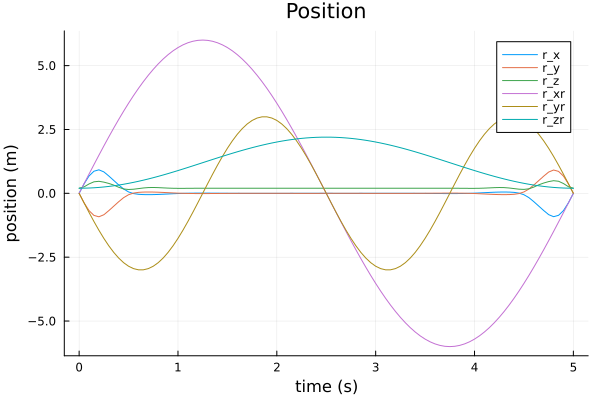

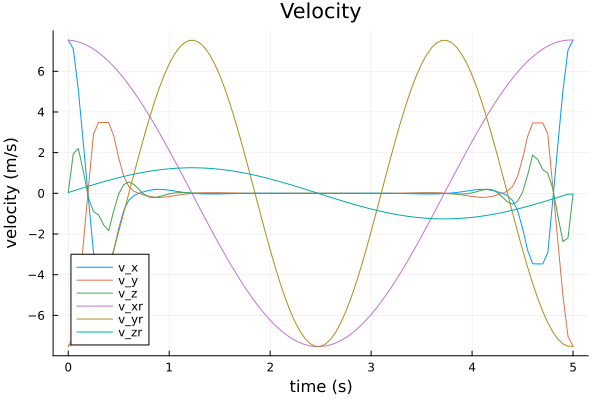

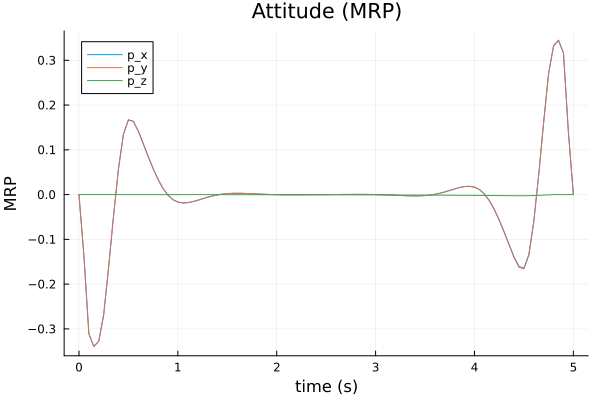

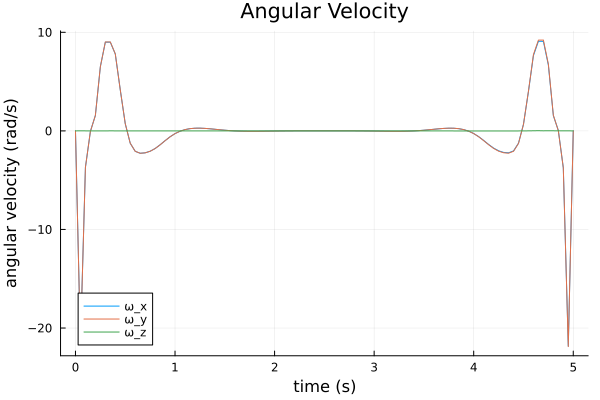

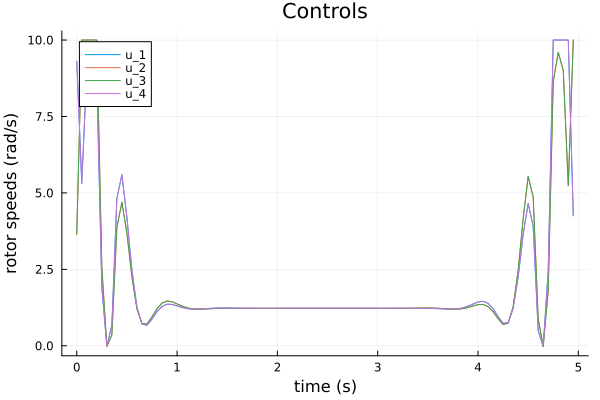

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
└ http://127.0.0.1:8700


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("traj" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("p94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s14" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x31, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s44" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x34, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s52" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x35, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p92" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x32], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p98" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x38], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p6" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x61, 0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x36], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p23" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x32, 0x33], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "p90" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x70, 0x39, 0x30], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "s94" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x74, 0x2f, 0x74, 0x72, 0x61, 0x6a, 0x2f, 0x73, 0x39, 0x34], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}())…)), "vic" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x76, 0x69, 0x63], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "target" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x63, 0x61, 0x74, 0x2f, 0x74, 0x61, 0x72, 0x67, 0x65, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{Any}(), ip"127.0.0.1", 8700))

In [17]:
using Plots
import MeshCat as mc 
using Printf

# ---------------plotting------------------
Xm = hcat(X...)
Um = hcat(U...)
t_vec = t_vec[1:N]
plot(t_vec, Xm[1:3,:]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_x" "r_y" "r_z"])
display(plot!(t_vec, Xref[1:3,1:N]', xlabel = "time (s)", ylabel = "position (m)",
                               title = "Position", label = ["r_xr" "r_yr" "r_zr"]))
plot(t_vec, Xm[4:6,:]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_x" "v_y" "v_z"])
display(plot!(t_vec, Xref[4:6,1:N]', xlabel = "time (s)", ylabel = "velocity (m/s)",
                               title = "Velocity", label = ["v_xr" "v_yr" "v_zr"]))
display(plot(t_vec, Xm[7:9,:]', xlabel = "time (s)", ylabel = "MRP",
                               title = "Attitude (MRP)", label = ["p_x" "p_y" "p_z"]))
display(plot(t_vec, Xm[10:12,:]', xlabel = "time (s)", ylabel = "angular velocity (rad/s)",
                               title = "Angular Velocity", label = ["ω_x" "ω_y" "ω_z"]))
display(plot(t_vec[1:end-1], Um', xlabel = "time (s)", ylabel = "rotor speeds (rad/s)",
                               title = "Controls", label = ["u_1" "u_2" "u_3" "u_4"]))
display(animate_quadrotor([Xm[:,i] for i=1:N], [Xref[:,i] for i=1:N], dt))